# Digits 분류하기
숫자 필기 데이터는 사이킷런 패키지에서 제공하는 분류용 예제 데이터

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
#층을 담는 그릇(Sequential은 keras에 포함되어 있는데
# 딥러닝 모델을 한층 한층 쌓기 쉽게 해주는 함수)
from tensorflow.keras.layers import Dense
#층을 만드는 것(각 층이 가질 특성을 각각 다르게 지정 가능) 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # 모델 최고값 저장
import warnings
warnings.filterwarnings("ignore")

In [2]:
# seed값 생성
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# 데이터 불러오기
from sklearn.datasets import load_digits
digits = load_digits()     # 1,979개의 이미지 데이터 로드

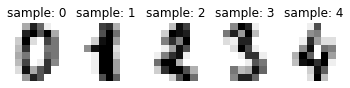

In [4]:
# 샘플 1,797 중 상위 5개의 샘플만 시각화
%matplotlib inline
import matplotlib.pyplot as plt

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:5]): # 5개의 샘플만 출력
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('sample: %i' % label)

In [5]:
# digits.data 첫번째 샘플 -> 전부 64차원의 벡터로 변환되어 저장된 상태 확인
print(digits.data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


# 데이터 전처리

In [6]:
# train, test 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, stratify=digits.target,
    random_state=seed, test_size=0.2
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

# 원-핫 인코딩

In [7]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# 훈련 데이터와 테스트 데이터에 대해서 원-핫 인코딩
print(y_train[:,:-1])
print(y_test[:,-1])

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [8]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dig_scaled = scaler.fit_transform(digits.data)
df = pd.DataFrame(dig_scaled, columns=digits.feature_names)
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,0.3125,0.8125,0.5625,0.0625,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.3750,0.8125,0.6250,0.0000,0.0000,0.0
1,0.0,0.0,0.0000,0.7500,0.8125,0.3125,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.6875,1.0000,0.6250,0.0000,0.0
2,0.0,0.0,0.0000,0.2500,0.9375,0.7500,0.0,0.0,0.0,0.0,...,0.3125,0.0,0.0,0.0,0.0000,0.1875,0.6875,1.0000,0.5625,0.0
3,0.0,0.0,0.4375,0.9375,0.8125,0.0625,0.0,0.0,0.0,0.5,...,0.5625,0.0,0.0,0.0,0.4375,0.8125,0.8125,0.5625,0.0000,0.0
4,0.0,0.0,0.0000,0.0625,0.6875,0.0000,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.1250,1.0000,0.2500,0.0000,0.0


# 모델 정의/설정

In [98]:
# 출력 데이터 크기:10개의 카테고리
num_classes = 10
# 모델 설정
model = Sequential([
    Dense(512, input_dim=64, activation='relu'),   #인풋딩 피쳐가 64개, 512개의 유닛을 가진 입력 layer 생성
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [99]:
# 모델 컴파일
model.compile(
    loss = 'binary_crossentropy',
    optimizer ='adam',
    metrics=['accuracy']
)

# 체크포인트 만들어서 모델 저장하기

In [100]:
# 모델 저장 조건 설정
modelpath = 'model/best_digit.h5'
checkpointer = ModelCheckpoint(
    filepath = modelpath,
    monitor='val_loss',
    verbose = 1,
    save_best_only = True
)

In [101]:
# 과적합을 방지하기 위해 Earlystopping 설정
# 학습 자동중단 설정
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=10) 
#10번 똑같은 정확도가 나오면 중단. 몇번 참느냐

# 모델 학습 및 저장

In [102]:
# 모델 실행
history =model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs=500, batch_size=200, verbose = 0,
    callbacks=[checkpointer, early_stopping_callback])   # 트레인셋의 일부를 떼서 시험(split)


Epoch 00001: val_loss improved from inf to 0.11833, saving model to model\best_digit.h5

Epoch 00002: val_loss improved from 0.11833 to 0.04408, saving model to model\best_digit.h5

Epoch 00003: val_loss improved from 0.04408 to 0.02650, saving model to model\best_digit.h5

Epoch 00004: val_loss improved from 0.02650 to 0.02131, saving model to model\best_digit.h5

Epoch 00005: val_loss improved from 0.02131 to 0.01389, saving model to model\best_digit.h5

Epoch 00006: val_loss improved from 0.01389 to 0.01229, saving model to model\best_digit.h5

Epoch 00007: val_loss did not improve from 0.01229

Epoch 00008: val_loss improved from 0.01229 to 0.01226, saving model to model\best_digit.h5

Epoch 00009: val_loss improved from 0.01226 to 0.01202, saving model to model\best_digit.h5

Epoch 00010: val_loss improved from 0.01202 to 0.01191, saving model to model\best_digit.h5

Epoch 00011: val_loss did not improve from 0.01191

Epoch 00012: val_loss did not improve from 0.01191

Epoch 0001

# 베스트 모델로 평가

In [103]:
from tensorflow.keras.models import load_model
best_model = load_model('model/best_digit.h5')    # 'model/best_digit.h5'쓰면 겹쳐서 가능

In [104]:
best_model.evaluate(X_test,y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9750


[0.016733689233660698, 0.9750000238418579]

# 훈련과정 시각화

In [105]:
# 학습셋의 정확도
y_acc = history.history['accuracy']

# 테스트셋 오차
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_acc))

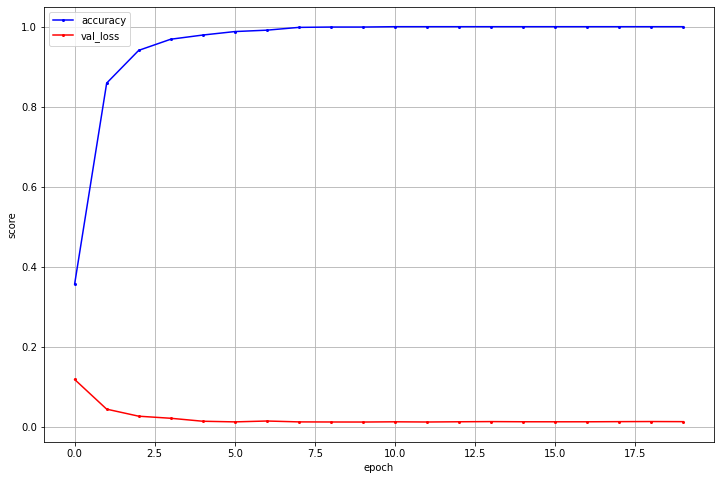

In [106]:
plt.figure(figsize=(12,8))

# 학습셋 정확도 라인
plt.plot(x_len, y_acc, 'bo-', markersize=2, label='accuracy')

# 태스트셋 오차 라인
plt.plot(x_len, y_vloss, 'ro-', markersize=2, label='val_loss')

plt.legend(loc='best')   #location  right, left, upper rigtht 등등 
plt.grid()   # 격자 
plt.xlabel('epoch')
plt.ylabel('score')

plt.show()